### DATA620 - Project 1

##### Date : June 15, 2018

##### Authors : Dhananjay Kumar, Sang Yoon Hwang, Matheesha Thambeliyagodage, Santosh Manjrekar

In this project we will analyse Marvel Super Heroes dataset and a additonal categorical data (gender) to the original dataset. 

In [51]:
# Import Libraries
import requests
import time
import csv
import json
import bs4
#import gender_guesser.detector as gender
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
import numpy as np
import operator
import pandas as pd
import networkx as nx
import graphistry
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [13]:
# Load Data

import sys
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_0c683be7da1a4afa9dff4d3e74df6e8d = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='adA2J5oNgPawOx24Jsa6H75Di50OtD_9F7GEmrXXOn2C',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_0c683be7da1a4afa9dff4d3e74df6e8d.get_object(Bucket='week1-donotdelete-pr-w507sjzvmr6k5c',Key='marvel-wikia-data.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
body = client_0c683be7da1a4afa9dff4d3e74df6e8d.get_object(Bucket='week1-donotdelete-pr-w507sjzvmr6k5c',Key='hero-network.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_2 = pd.read_csv(body)
df_data_2.columns = ['Source', 'Target']

df_data_2['Gender'] = ""
df_data_1['NAME'] = "" 
    
     
for index, row in df_data_1.iterrows():
    sName2 = row['name']
    sName2 = sName2.upper()
    sNameDict2 = sName2.split('(')
    df_data_1.set_value(index, 'NAME', sNameDict2[0])




### Clean Data

In [14]:
# Clean data class

def cleandf2():
    for index, row in df_data_2.iterrows():
        sName = row['Source']
        sNameDict = sName.split('/')
        sNameDict = sNameDict[0].split('/')
        df_data_2.set_value(index, 'Source', sNameDict[0])
        sNameDict = sName.split(',')
        try:
            sName = sNameDict[1]
            if len(sNameDict[1]) > 1:
                sName = sNameDict[1] + " " + sNameDict[0]
                df_data_2.set_value(index, 'Source', sName)
        except IndexError:
            sName = ""
            
        sName = row['Source']
        sName = sName.replace("/", " ")
        sName = sName.replace("II", " ")
        sName = sName.replace("III", " ")
      #  sName = sName.replace("IV", " ")
      #  sName = sName.replace("VI", " ")
        sName = sName.replace("VII", " ")
        sName = sName.replace("VIII", " ")
        sName = sName.replace("IRON MAN IV", "IRON MAN")
        sName = sName.replace("'", " ")
        sName = sName.replace(",", " ")
        sName = sName.replace("-", " ")
        sName = sName.replace("_", " ")
        sName = sName.replace("?", " ")
        sName = sName.replace("[", " ")
        sName = sName.replace("]", " ")
        sName = sName.replace("(", " ")
        sName = sName.replace(")", " ")
        df_data_2.set_value(index, 'Source', sName)

    for index, row in df_data_2.iterrows():
        sName = row['Target']
        sNameDict = sName.split('/')
        sNameDict = sNameDict[0].split('/')
        df_data_2.set_value(index, 'Target', sNameDict[0])
        sNameDict = sName.split(',')
        try:
            sName = sNameDict[1]
            if len(sNameDict[1]) > 1:
                sName = sNameDict[1] + " " + sNameDict[0]
                df_data_2.set_value(index, 'Target', sName)
        except IndexError:
            sName = ""
                
        sName = row['Target']
        sName = sName.replace("/", " ")
        sName = sName.replace("?", " ")
        sName = sName.replace("[", " ")
        sName = sName.replace("]", " ")
        sName = sName.replace("(", " ")
        sName = sName.replace(")", " ")
        sName = sName.replace("'", " ")
        sName = sName.replace(",", " ")
        sName = sName.replace("-", " ")
        sName = sName.replace("_", " ")
        sName = sName.replace("IRON MAN IV", "IRON MAN")
        sName = sName.replace("II", " ")
        sName = sName.replace("III", " ")
      #  sName = sName.replace("IV", " ")
      #  sName = sName.replace("VI", " ")
        sName = sName.replace("VII", " ")
        sName = sName.replace("VIII", " ")
        df_data_2.set_value(index, 'Target', sName)         


In [15]:
# Get Clean Data
cleandf2()

For better analyses,  we will extract 50 top super heroes

In [16]:
# Get List of TOP 50 Superheroes
freqList = df_data_2['Source'].value_counts().head(50).index.tolist()
len(freqList)

50

In [17]:
# Get Unique dataframe of top 50 Superheroes from dataframe 2
df_data_3 = pd.DataFrame([])
df_data_3['Name'] =  df_data_2.Source.loc[(df_data_2['Source'].isin(freqList) == True)]
df_data_3 = df_data_3.drop_duplicates()
df_data_3['Gender'] = ""

### Add Gender

We already have data in csv file gathered from Web Scraping Wikipedia. We will use this data to add gender to our original dataset. In doing so we will leverage fuzzy pattern matching.

In [18]:
# Add Gender to df_data_2
def addGender():
        
    for index, row in df_data_3.iterrows():
        sName = row['Name']
        gFound = ""
        lvOld = 0
        lvName = ""
        lvGender = ""
        mList = ["MAN", "SIR","CANNONBALL", "PRINCE","MR.","THING", "QUICKSILVER", "STRANGE"]
        fList = ["WOMAN", "SHADOWCAT", "WIDOW", "GIRL", "MRS.", "SHE", "PRINCESS", "QUEEN", "WITCH","CAT"]
        sNameDict = sName.split()
        try:
            if (sNameDict[0] in mList or sNameDict[1] in mList):
                gFound = 'MALE'
                df_data_3.set_value(index, 'Gender', gFound)      
                continue
            elif (sNameDict[0] in fList or sNameDict[1] in fList):
                gFound = 'FEMALE'
                df_data_3.set_value(index, 'Gender', gFound)      
                continue     
        except IndexError:
            sNameDict = 0
        for i, row2 in df_data_1.iterrows():
            lvMatch = fuzz.ratio(sName, row2['NAME'])
            if lvMatch > lvOld:
                lvOld = lvMatch
                lvName = row2['NAME']
                lvGender = row2['SEX']


        if lvOld > 60:
            if lvGender == 'Male Characters':
                gFound = 'MALE'
            elif lvGender == 'Female Characters':
                gFound = 'FEMALE'                               
            df_data_3.set_value(index, 'Gender', gFound)
            
                
        
                    
                
    return(df_data_3)

In [19]:
df_data_4 = addGender()

In [20]:
for index, row in df_data_2.iterrows():
    gFound = df_data_4.Gender[df_data_4['Name'] == row['Source']].astype(str)
    gFound = gFound.to_string()
#    gFound = ''.join([i for i in gFound if not i.isdigit()])
    if " FEMALE" in gFound:
        gFound = 'FEMALE'
        df_data_2.set_value(index, 'Gender', gFound)
    elif " MALE" in gFound:
        gFound = 'MALE'
        df_data_2.set_value(index, 'Gender', gFound)
    else:
        continue
         #df_data_2.drop(index, inplace=True)
    

In [21]:
df_data_2 = df_data_2[df_data_2.Gender != '']

In [22]:
df_data_2.head()

,Source,Target,Gender
1,BLACK PANTHER,PRINCESS ZANDA,MALE
4,BLACK PANTHER,PRINCESS ZANDA,MALE
14,IRON MAN,DOMINIC FORTUNE,MALE
15,IRON MAN,CLYTEMNESTRA ERWIN,MALE
16,IRON MAN,IRON MAN,MALE


### Gender Distribution

In [23]:
df_data_2.Gender.value_counts()

MALE      134061
FEMALE     39288
Name: Gender, dtype: int64

### Top 10 Male Super Heroes

In [24]:
#Top 10 Male Super Heroes
df_data_2.Source[df_data_2['Gender'] == 'MALE'].value_counts().head(10)
#df_data_2.Source.value_counts().head(10)

CAPTAIN AMERICA    8149
IRON MAN           6938
SPIDER MAN         6652
THOR               5712
THING              5369
WOLVERINE          5230
VISION             5067
HUMAN TORCH        4970
MR. FANTASTIC      4788
BEAST              4628
Name: Source, dtype: int64

### Top 10 Female Super Heroes

In [25]:
#Top 10 Female Super Heroes
df_data_2.Source[df_data_2['Gender'] == 'FEMALE'].value_counts().head(10)

SCARLET WITCH           5184
INVISIBLE WOMAN         4723
WASP                    4452
STORM                   4170
MARVEL GIRL             3667
ROGUE                   2918
SHE HULK                2797
BLACK WIDOW             2656
 MARY  WATSON PARKER    2570
PSYLOCKE                2210
Name: Source, dtype: int64

### Visualization

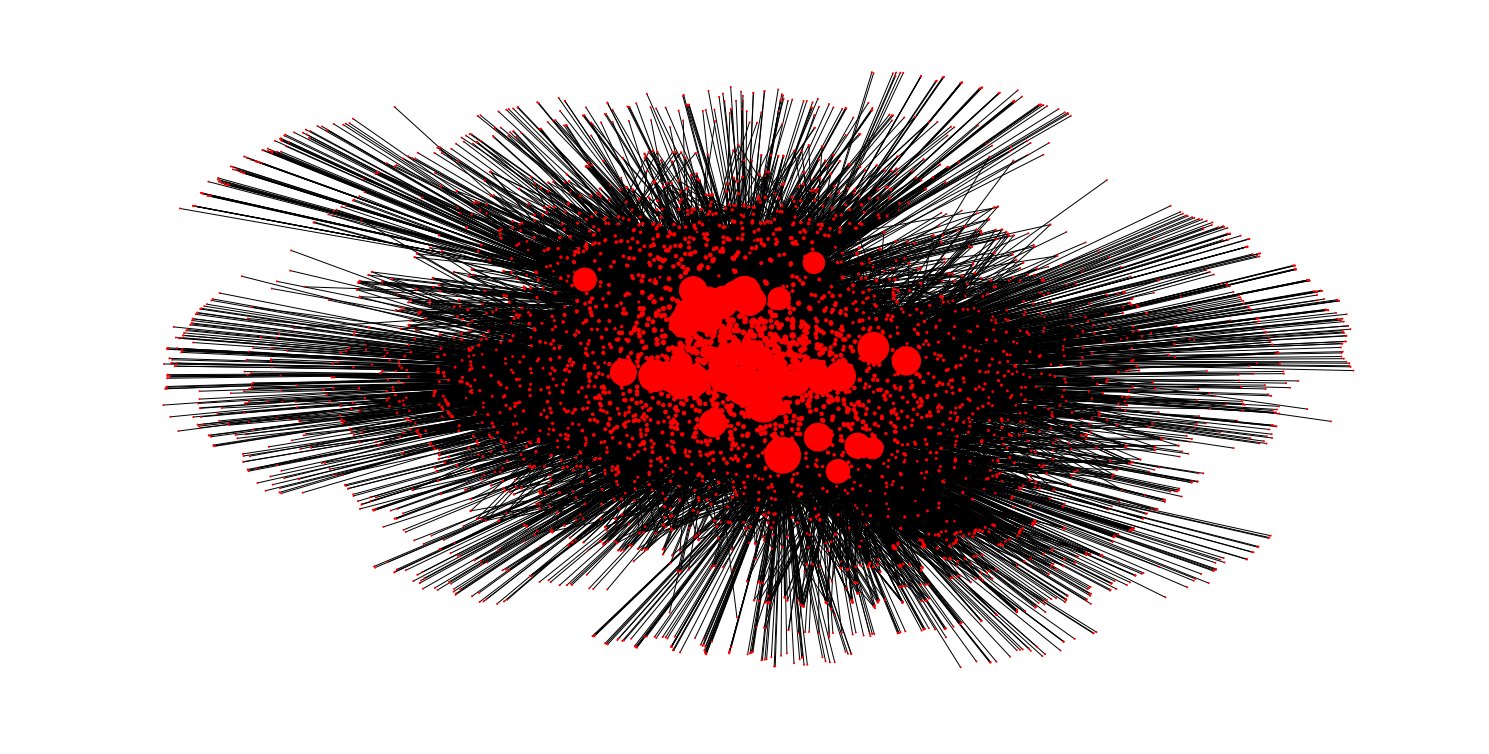

In [26]:
# Create Graph from Networkx  pG - Parent Graph
pG = nx.from_pandas_dataframe(df_data_2,source='Source', target='Target', create_using=nx.Graph())
        
# Plot Parent Graph - pG
deg = [val for (node, val) in pG.degree()]
plt.show(nx.draw(pG ,node_size = [v for v in deg]))
#plt.show(nx.draw(pG))

In [27]:
#color_map = []
#for node in cG:
 #   gFound = df_data_4.Gender[df_data_4['Name'] == node].astype(str)
  #  gFound = gFound.to_string()
   # if " FEMALE" in gFound:
    #    color_map.append('blue')
   # elif " MALE" in gFound:
    #    color_map.append('red')
   # else:
    #    color_map.append('yellow')

In [32]:

body = client_0c683be7da1a4afa9dff4d3e74df6e8d.get_object(Bucket='week1-donotdelete-pr-w507sjzvmr6k5c',Key='key.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_5 = pd.read_csv(body)
gKey = df_data_5.key.head(1).to_string()
graphistry.register(key=gKey[5:])
#graphistry.register('aa19b9109a0c9cc20ad91fb6aa62350037fbb05f1d6f1ed0596b3c244e4f32538b6cbfd421248463507f219431e11063')

### Interactive Visualization

In [33]:


gG = graphistry.bind(source='Source', destination='Target')
gG = gG.graph(df_data_2)
gG.plot()

### Graph Stats

In [34]:
# Is pG connected , not
nx.is_connected(pG)

True

In [35]:
# Vital stats for pG
print(nx.info(pG))

Name: 
Type: Graph
Number of nodes: 4576
Number of edges: 34811
Average degree:  15.2146


In [36]:
# Distance Metric
print('center =', nx.center(pG))
print('diameter =', nx.diameter(pG))
print('radius =', nx.radius(pG))

center = ['SHE HULK', 'INVISIBLE WOMAN', 'SCARLET WITCH', 'THING', 'NIGHTCRAWLER', 'QUASAR  I', 'CRYSTAL  INHUMAN ', 'SPIDER MAN', 'FIRESTAR', 'ANGEL', 'CYCLOPS', 'PROFESSOR X', 'UATU', 'MR. FANTASTIC', 'WONDER MAN', 'BEAST', 'ROGUE ', 'STORM', 'CAPTAIN AMERICA', 'WASP', 'THOR', 'SUB MARINER', 'ICEMAN', 'HERCULES  GREEK GOD ', 'HUMAN TORCH', 'COLOSSUS  ', 'DR. STRANGE', 'HAWK', 'ANT MAN', 'BLACK WIDOW', ' FRANKLIN B RICHARDS', 'MARVEL GIRL', 'IRON MAN', 'VISION ', ' COL. NICHOLAS  FURY', 'HULK', 'WOLVERINE']
diameter = 4
radius = 2


In [37]:
# Top 5 - Most Connected Superheros in Ascending Order

nDf = pd.DataFrame(list(nx.degree(pG)), columns=['Name', 'Degree'])
nDf.sort_values('Degree', inplace=True)
nDf.tail()

,Name,Degree
3068,SCARLET WITCH,1003
4334,WOLVERINE,1035
3936,IRON MAN,1213
3504,SPIDER MAN,1284
2180,CAPTAIN AMERICA,1426


## Centrality

In [68]:
# Closeness centrality
closeness = nx.closeness_centrality(pG)
closeness = sorted(closeness.items(), key=operator.itemgetter(1))
clDf = pd.DataFrame(columns=['Node_Name', 'Closeness'], data=closeness)
clDf.sort_values(['Closeness'], ascending=False, inplace=True)

# Betweenness centrality
betweenness = nx.betweenness_centrality(pG)
betweenness = sorted(betweenness.items(), key=operator.itemgetter(1))
btDf = pd.DataFrame(columns=['Node_Name', 'Betweenness'], data=betweenness)
btDf.sort_values(['Betweenness'], ascending=False, inplace=True)

resultclDf = pd.concat([clDf, btDf], axis=1)
resultclDf.head(10)

,Node_Name,Closeness,Node_Name,Betweenness
0,MINDSTORM,0.342133,HAUS,0.0
1,YANO,0.342133,SCALEFACE,0.0
2,LYNN WALSH,0.342133,TIMESLOT,0.0
3,TYPEFACE,0.342133,RIOT,0.0
4,DET. COFFY,0.342133,DIVINITY,0.0
5,GEORGE VANDERGILL,0.342133,PHILIP WATSON,0.0
6,FAST FREDDY GLAZER,0.342133,GWEN STACY,0.0
7,NIGHTWATCH,0.342133,TEMPUS,0.0
8,MACE,0.342133,NUKE,0.0
9,JAKE CARLTON,0.342133,KARIMA,0.0


### Captain America vs Scarlet Witch

In [40]:
from pandasql import *

pysqldf = lambda q: sqldf(q, globals())

q = """
SELECT
*
FROM
 df_data_2 
WHERE
 (Source = 'CAPTAIN AMERICA' OR
  Source = 'SCARLET WITCH');
"""

df_data_6 = pysqldf(q)

In [41]:
df_data_6.Source.value_counts()

CAPTAIN AMERICA    8149
SCARLET WITCH      5184
Name: Source, dtype: int64

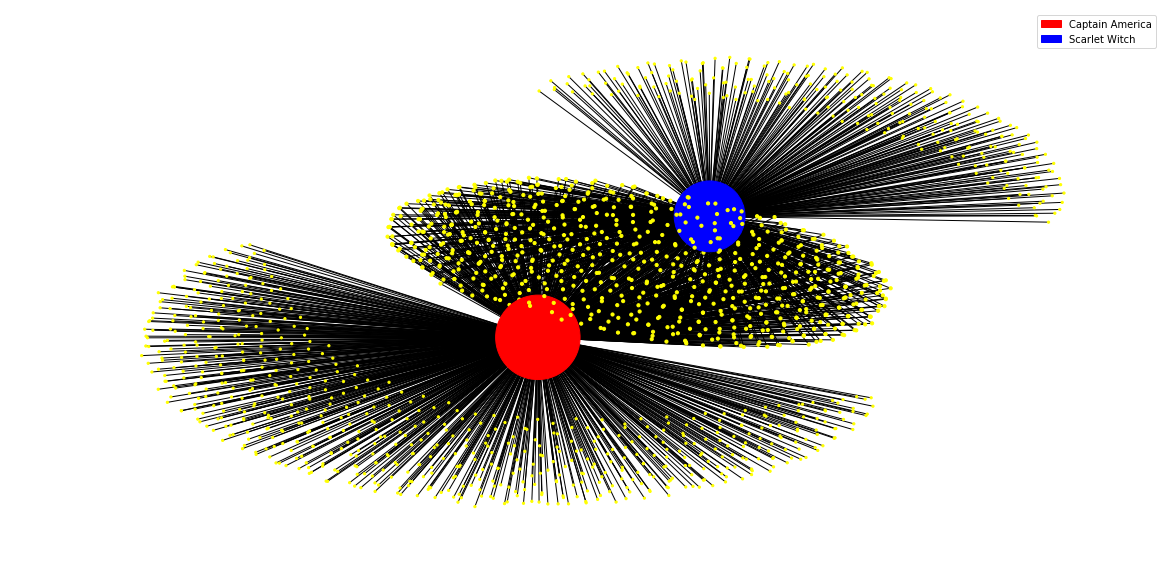

In [49]:
# Create Graph from Networkx  cG - Child Graph
import matplotlib.patches as mpatches
cG = nx.from_pandas_dataframe(df_data_6,source='Source', target='Target', create_using=nx.Graph())
color_map = []
for node in cG:
    if node == 'CAPTAIN AMERICA':
        color_map.append('red')
    elif node == 'SCARLET WITCH':
        color_map.append('blue')
    else:
        color_map.append('yellow')
        
deg = [val for (node, val) in cG.degree()]
red_patch = mpatches.Patch(color='red', label='Captain America')
blue_patch = mpatches.Patch(color='blue', label='Scarlet Witch')
plt.legend(handles=([red_patch, blue_patch]))
plt.show(nx.draw(cG, node_color = color_map, node_size = [v*5 for v in deg]))


### Graph Stats

In [43]:
# Vital stats for pG
print(nx.info(cG))

Name: 
Type: Graph
Number of nodes: 1679
Number of edges: 2427
Average degree:   2.8910


In [44]:
# Distance Metric
print('diameter =', nx.diameter(cG))
print('radius =', nx.radius(cG))

diameter = 3
radius = 2


In [45]:
### Interactive Visualization

In [46]:
cgG = graphistry.bind(source='Source', destination='Target')
cgG = cgG.graph(df_data_6)
cgG.plot()

In [47]:
nDf2 = pd.DataFrame(list(nx.degree(cG)), columns=['Name', 'Degree'])
nDf2.sort_values('Degree', inplace=True)
nDf2.tail(2)

,Name,Degree
175,SCARLET WITCH,1003
1106,CAPTAIN AMERICA,1426


### Closeness Centrality

In [52]:
# Closeness centrality
closeness = nx.closeness_centrality(cG)
closeness = sorted(closeness.items(), key=operator.itemgetter(1))
clDf = pd.DataFrame(columns=['Node_Name', 'Closeness'], data=closeness)
clDf.sort_values(['Closeness'], ascending=False, inplace=True)
clDf.head(10)

,Node_Name,Closeness
1678,CAPTAIN AMERICA,0.868530
1677,SCARLET WITCH,0.713132
1174,CRIMSON DYNAMO I,0.500298
1183,GAEA,0.500298
1182,BLACK KNIGHT V DOPPE,0.500298
1181,YELLOW CLAW,0.500298
1180,AMERICAN EAGLE I,0.500298
1179,ALICE NUGENT,0.500298
1178,TEMPEST,0.500298
1177,THENA,0.500298


### Betweenness Centrality

In [54]:
betweenness = nx.betweenness_centrality(cG)
betweenness = sorted(betweenness.items(), key=operator.itemgetter(1))
btDf = pd.DataFrame(columns=['Node_Name', 'Betweenness'], data=betweenness)
btDf.sort_values(['Betweenness'], ascending=False, inplace=True)
btDf.head(10)

,Node_Name,Betweenness
1678,CAPTAIN AMERICA,0.742137
1677,SCARLET WITCH,0.379186
1115,WIZARD,0.000000
1126,NORM WEBSTER,0.000000
1125,VIZIER,0.000000
1124,U MAN,0.000000
1123,TAIFU,0.000000
1122,LOVE,0.000000
1121,PEGGY CHANDLER,0.000000
1120,BARIUM,0.000000


### Eigen Vector

In [57]:
evC = nx.eigenvector_centrality_numpy(cG)

In [67]:
evCdf = pd.DataFrame([evC.items()]).T
evCdf.columns = ['Name - Centrality']

evCdf.head(10)

,Name - Centrality
0,"(NUKE, 0.00941304009195)"
1,"(BIG ONE, 0.00941304009195)"
2,"(SHE HULK, 0.0219910251515)"
3,"(RIOT, 0.0125779850596)"
4,"(DIVINITY, 0.0219910251515)"
5,"(CAPTAIN AMERICA IV, 0.0219910251515)"
6,"(SCARBO, 0.0125779850596)"
7,"(MAXIMUS INHUMAN , 0.0219910251515)"
8,"(TEMPUS, 0.0125779850596)"
9,"( MADELYNE MA SUMMERS, 0.0219910251515)"
